In [11]:
%pip install mosek
%pip install numpy 
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.


  Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
Using cached matplotlib-3.10.7-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl (225 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)

   ------------- -------------------------- 1/3 [contourpy]
   ------------- -------------------------- 1/3 [contourpy]
   -------------------------- ------------- 2/3 [matplotlib]
   -------------------------- ------------- 2/3 [matplotlib]
   -------------------------- ------------- 2/3 [matplotlib]
   -------------------------- ------------- 2/3 [matplotlib]
   -------------------------- ------------- 2/3 [matplotlib]
   -------------------------- ------------- 2/3 [matplotlib]
   -------------------------- ------------- 2/3 [matplotlib]
   -------------------------- ------------- 2/3 [matpl

In [18]:
import mosek.fusion as mf
import numpy as np
import time
import matplotlib.pyplot as plt
import os

In [ ]:
# The following code is made for the MOSEK implementation of the SDP formulation of the Quantum Mechanical Bootstrap on the Harmonic Potential

In [ ]:
def moment_list_generator(energy, no_of_terms: int) -> list:
    """
    Generate a list of moments for a given energy value.

    Parameters
    ----------
    energy
        The energy value used in the recurrence relation.
    no_of_terms : int
        Total number of terms (moments) to generate.

    Returns
    -------
    moment_list : list
        The list of computed moments.
    """

    # Initializion
    moment_list = [1, 0, energy, 0]

    # Recurrence relation 
    for i in range(4, no_of_terms):
        new_moment = (
            2 * energy * (i - 1) * moment_list[i - 2]
            + ((i - 1) * (i - 2) * (i - 3) * moment_list[i - 4]) / 4
        ) / i

        moment_list.append(new_moment)

    return moment_list

In [ ]:
def Hankel_matrix_generator(moment_list: list, K: int):
    """
    Construct a K * K Hankel matrix from a list of moments.

    Parameters
    ----------
    moment_list : list
        List of moments x_0, x_1, ..., used to fill the Hankel matrix.
        Assumes length >= 2K - 1.
    K : int
        Dimension of the (square) Hankel matrix.

    Returns
    -------
    matrix : list of lists
        A K * K Hankel matrix where M[i][j] = moment_list[i + j].
    """

    matrix = []

    for i in range(K):
        row = []
        for j in range(K):
            row.append(moment_list[i + j])
        matrix.append(row)

    return matrix

In [ ]:
def bootstrap_max_t(M):
    """
    Compute the maximum value of t such that M - tI is PSD.
    Implemented as an SDP using MOSEK Fusion.

    Parameters
    ----------
    M : array-like
        Input square matrix.

    Returns
    -------
    val : float or None
        The maximal t satisfying M - tI >= 0, or None if the solver fails.
    """

    # Matrix size
    n = np.array(M).shape[0]

    # Create optimization model
    model = mf.Model()

    # Scalar variable t (unbounded)
    t = model.variable("t", mf.Domain.unbounded())

    # PSD matrix variable X
    X = model.variable("X", [n, n], mf.Domain.inPSDCone())

    # Dense Fusion matrices
    M_f = mf.Matrix.dense(np.array(M))
    I_f = mf.Matrix.eye(n)

    # Expression:  M - tI
    M_minus_tI = mf.Expr.sub(M_f, mf.Expr.mul(t, I_f))

    # Constraint:  X = M - tI
    model.constraint(mf.Expr.sub(X, M_minus_tI), mf.Domain.equalsTo(0.0))

    # Objective: Maximize t
    model.objective(mf.ObjectiveSense.Maximize, t)

    try:
        model.solve()
        val = t.level()[0]  # Extract the optimized scalar value
    except Exception:
        val = np.nan # Return NaN if model fails
    finally:
        model.dispose() # Clear model to avoid memory cluttering

    return val

In [ ]:
# List of ranks K for which the bootstrap should run
K_list = [5, 8, 10, 13, 15, 18, 20]

# Energy values over which the search is performed
energy_list = list(np.arange(0, 3, 0.001))

# Dictionary: K ; list of t-values (one for each energy)
t_val_dict = {}

# Start performance timer
start = time.perf_counter()

for K in K_list:
    # Temporary container for results corresponding to the current K
    t_val_list = []

    for energy in energy_list:
        try:
            # Generate moments and construct the Hankel matrix
            moment_list = moment_list_generator(energy, 2 * K + 1)
            matrix = Hankel_matrix_generator(moment_list, K)

            # Solve the SDP and store log_10(|t|)
            t_val = bootstrap_max_t(matrix)
            t_val_list.append(np.log10(abs(t_val)))

        except Exception as e:
            # On solver or numerical failure, append NaN
            t_val_list.append(np.nan)

    # Save results for this rank K
    t_val_dict[K] = t_val_list

# End performance timer
end = time.perf_counter()

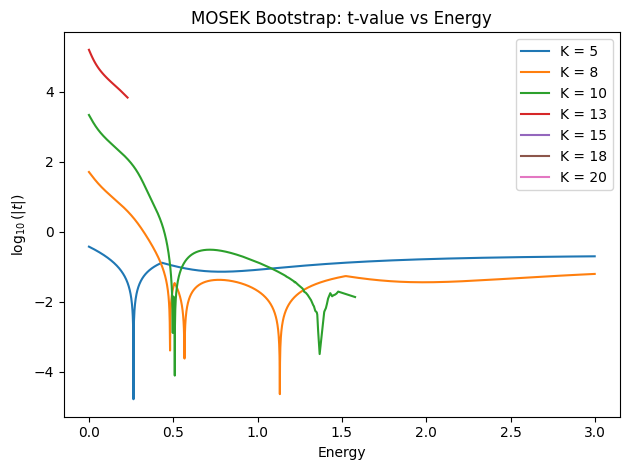

In [ ]:
def plot_mosek_results(K_list, energy_list, t_val_dict, save_dir=r"D:\BTP\Report\pictures"):
    """
    Plot log10(|t|) vs energy for different values of K using stored MOSEK results.

    Parameters
    ----------
    K_list : list
        List of K values (matrix ranks) used in the bootstrap.
    energy_list : list or array
        Energies corresponding to each t-value.
    t_val_dict : dict
        Dictionary mapping K ; list of t-values (possibly with NaNs).
    save_dir : str
        Directory where the plot will be saved.
    """

    plt.figure()

    # Plot each K-curve separately
    for K in K_list:
        y = np.array(t_val_dict[K])      # t-values for this K
        x = np.array(energy_list)        # Corresponding energies

        mask = ~np.isnan(y)              # Ignore NaNs in the plot
        plt.plot(x[mask], y[mask], label=f"K = {K}")

    # Axis labels and title
    plt.xlabel("Energy")
    plt.ylabel(r"$\log_{10}(|t|)$")
    plt.title("MOSEK Bootstrap: t-value vs Energy")
    plt.legend()
    plt.tight_layout()

    # File path for saving the figure
    filename = "MOSEK_Bootstrap_t_value_vs_Energy.png"
    filepath = os.path.join(save_dir, filename)

    # Save the figure as PNG
    plt.savefig(filepath, dpi=300, bbox_inches="tight")

    # Display the plot
    plt.show()


# Call the plotting function
plot_mosek_results(K_list, energy_list, t_val_dict)

In [ ]:
# Print total runtime of the bootstrap loop
print(end - start)

897.8474122998305
